# InceptionTime Model 
# on Time Series EMG Classification on Ninapro Dataset [Wrist Motions]

InceptionTime is a 1D Convolution based Deep Neural Network model which is currently quoted as the state of the art TSC model from the published paper [InceptionTime: Finding AlexNet for Time Series Classification](https://arxiv.org/abs/1909.04939).

#### Understanding Data
Input data will be a 2D matrix which has rows as the time-step and columns as emg channels.
Window Length X No.EMG Sensors

#### Model Accuracy  Results

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import warnings
# warnings.filterwarnings(action='once')
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

## Import the Prepared Datasets

In [2]:
X = np.load('prepared_data/X_all_wrist_150_30.npy')
y = np.load('prepared_data/Y_hot_all_wrist_150_30.npy')

In [3]:
X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2]))
X.shape

(1094599, 150, 12)

In [4]:
y.shape

(1094599, 10)

### Merge, Shuffle and Split

In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

print('X Train Shape =',X_train.shape)
print('Y Train Shape =',y_train.shape)
print('X Test Shape =',X_test.shape)
print('Y Test Shape =',y_test.shape)

X Train Shape = (875679, 150, 12)
Y Train Shape = (875679, 10)
X Test Shape = (218920, 150, 12)
Y Test Shape = (218920, 10)


In [6]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [7]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [14]:
 clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=10,
                            verbose=True,batch_size=500,nb_epochs=10,nb_filters=32,
                            depth=6, kernel_size=25)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 12)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 150, 32)      384         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 150, 12)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 150, 32)      24576       conv1d_32[0][0]                  
____________________________________________________________________________________________

In [21]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/10
1752/1752 [==============================] - 259s 148ms/step - loss: 0.1473 - accuracy: 0.9505 - val_loss: 0.3068 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 2/10
1752/1752 [==============================] - 270s 154ms/step - loss: 0.1450 - accuracy: 0.9511 - val_loss: 0.3008 - val_accuracy: 0.9149 - lr: 0.0010
Epoch 3/10
1752/1752 [==============================] - 271s 155ms/step - loss: 0.1435 - accuracy: 0.9516 - val_loss: 0.3298 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 4/10
1752/1752 [==============================] - 272s 155ms/step - loss: 0.1412 - accuracy: 0.9524 - val_loss: 0.3179 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 5/10
1752/1752 [==============================] - 271s 155ms/step - loss: 0.1401 - accuracy: 0.9526 - val_loss: 0.3108 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 6/10
1752/1752 [==============================] - 271s 154ms/step - loss: 0.1377 - accuracy: 0.9534 - val_loss: 0.3256 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 7/10
1752/1752 [============

## Plot Results

In [56]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [57]:
metrics_df

,precision,accuracy,recall,duration
0,0.711466,0.916049,0.582194,1135.815791


<AxesSubplot:title={'center':'Loss'}>

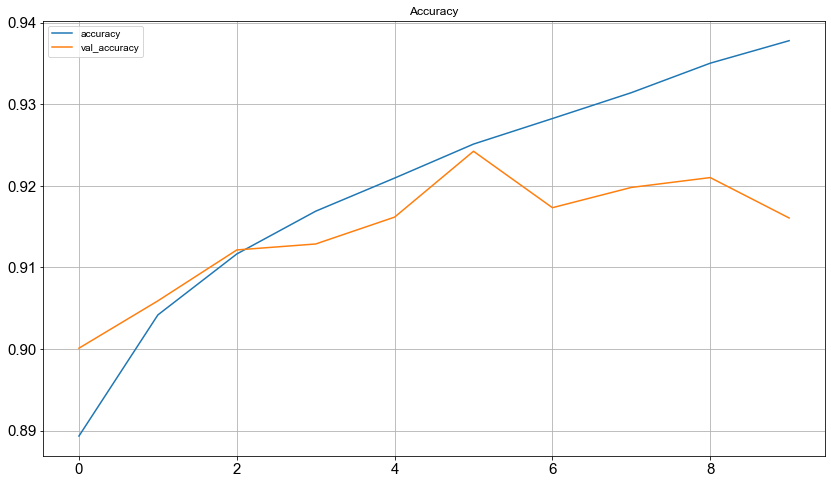

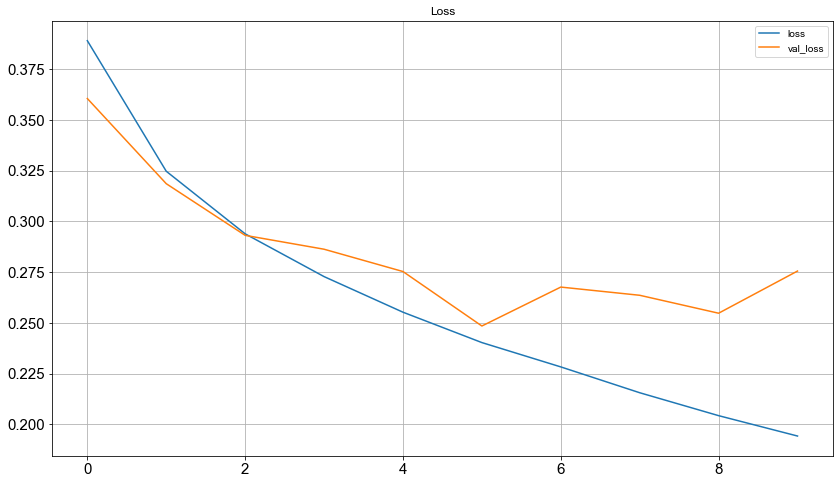

In [58]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

# Import Model and Classify Function Definition

In [ ]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

model = load_model('best_model_93.hdf5')
# model.summary()

def classify_emg(data):
    data = np.array(data) 
    data = np.reshape(data,(1,20,5))
    pred = model.predict(data,batch_size=1)[0]
#     print(pred)
    if(pred[0]>pred[1]):
        return 'Pronation'
    else:
        return 'Radial'

## Real time CNN Classifier Example
**Input Data** - The single Input data matrix sent in 20Khz freaquency,Has rows as time steps and columns as feature

### Input Sequence Data from DF

In [ ]:
# Total Pronation sequences = 330709
# Total Radial sequences = 148426 

sequence = 50 

df = pronation_df.reset_index(drop=True)
# df = radial_df.reset_index(drop=True)

data = df.loc[sequence*10:sequence*10+19] # The 20 step data Input Matrix
print('Input Data')
print(data.drop(['Label'],1).shape)
data

In [ ]:
print('True = ',data['Label'].tolist()[0])
data = data.drop(['Label'],1)
print('Predicted = ',classify_emg(data)) # Predict

### with Testing Dataset

In [ ]:
n = 2 
data = X_test[n] 
true = y_test[n]
print('Input shape = ',data.shape)


In [ ]:
if(true[0]==1):
    print('True = Pronation')
else:
    print('True = Radial')
print('Predicted = ',classify_emg(data)) # Predict